In [1]:
import logging

import numpy as np
import probtorch
import torch

import bouncing_ball
import bouncing_ball_data
import combinators
import smc
import utils

In [2]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [3]:
## dataset parameters
T = 50 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 10 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [4]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [5]:
trajectory = torch.Tensor(STATEs[0])
displacements = torch.Tensor(Disps[0])

generative = {}

for i, point in enumerate(trajectory):
    generative['position_%d' % i] = torch.Tensor(point[:2])
    if i >= 1:
        generative['displacement_%d' % i] = displacements[i-1]

In [6]:
num_particles = 500

In [7]:
bouncing_ball_step = combinators.Model(bouncing_ball.bouncing_ball_step, {}, {
    'delta_t': torch.ones(1),
    'directions': torch.Tensor([[1, 1], [-1, 1], [1, -1], [-1, -1]]) * (1/np.sqrt(2)),
})

In [8]:
init_bouncing_ball = combinators.Model(bouncing_ball.init_bouncing_ball, {
    'position_0': {
        'loc': torch.rand(2) * Boundary,
        'scale': torch.ones(2),
    },
    'speed': {
        'loc': torch.zeros(1),
        'scale': torch.ones(1),
    },
    'angle': {
        'low': torch.zeros(1),
        'high': torch.ones(1) * np.pi/2,
    },
    'doubt': {
        'loc': torch.zeros(1),
        'scale': torch.ones(1),
    },
    'noise': {
        'loc': torch.ones(1) * np.log(0.5),
        'scale': torch.ones(1),
    },
    'Pi_0': {
        'concentration': torch.ones(4),
    },
    'Pi_1': {
        'concentration': torch.Tensor([0.40, 0.20, 0.20, 0.20]),
    },
    'Pi_2': {
        'concentration': torch.Tensor([0.20, 0.40, 0.20, 0.20]),
    },
    'Pi_3': {
        'concentration': torch.Tensor([0.20, 0.20, 0.40, 0.20]),
    },
    'Pi_4': {
        'concentration': torch.Tensor([0.20, 0.20, 0.20, 0.40]),
    },
    
}, {
    'directions': torch.Tensor([[1, 1], [-1, 1], [1, -1], [-1, -1]]) * (1/np.sqrt(2)),
})

In [9]:
smc_runner = smc.smc(bouncing_ball_step, len(trajectory) - 1)

In [10]:
inference, init_bouncing_ball_params = smc.variational_smc(num_particles, init_bouncing_ball, smc_runner, 500, generative,
                                                           use_cuda=False)

07/30/2018 12:23:47 Variational SMC ELBO=-1.84689978e+03 at epoch 1
07/30/2018 12:23:48 Variational SMC ELBO=-2.04368811e+03 at epoch 2
07/30/2018 12:23:50 Variational SMC ELBO=-1.93668970e+03 at epoch 3
07/30/2018 12:23:51 Variational SMC ELBO=-1.65230396e+03 at epoch 4
07/30/2018 12:23:52 Variational SMC ELBO=-1.91996277e+03 at epoch 5
07/30/2018 12:23:54 Variational SMC ELBO=-2.04635986e+03 at epoch 6
07/30/2018 12:23:55 Variational SMC ELBO=-1.63940161e+03 at epoch 7
07/30/2018 12:23:56 Variational SMC ELBO=-1.99439441e+03 at epoch 8
07/30/2018 12:23:58 Variational SMC ELBO=-1.64667053e+03 at epoch 9
07/30/2018 12:23:59 Variational SMC ELBO=-1.40023352e+03 at epoch 10
07/30/2018 12:24:00 Variational SMC ELBO=-1.23140747e+03 at epoch 11
07/30/2018 12:24:02 Variational SMC ELBO=-2.09202612e+03 at epoch 12
07/30/2018 12:24:03 Variational SMC ELBO=-1.52288269e+03 at epoch 13
07/30/2018 12:24:04 Variational SMC ELBO=-1.48936377e+03 at epoch 14
07/30/2018 12:24:06 Variational SMC ELBO=-2

In [11]:
for t in range(len(trajectory)):
    key = 'position_%d' % t
    accuracy = ((inference[key].value - utils.optional_to(generative[key], inference[key].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

SMC MSE at time 0: 50.131477
SMC MSE at time 1: 58.150826
SMC MSE at time 2: 62.297699
SMC MSE at time 3: 62.934635
SMC MSE at time 4: 72.758118
SMC MSE at time 5: 72.982162
SMC MSE at time 6: 78.368484
SMC MSE at time 7: 75.581886
SMC MSE at time 8: 77.524559
SMC MSE at time 9: 69.363586
SMC MSE at time 10: 70.028740
SMC MSE at time 11: 68.130142
SMC MSE at time 12: 69.473679
SMC MSE at time 13: 62.722679
SMC MSE at time 14: 72.522141
SMC MSE at time 15: 80.105286
SMC MSE at time 16: 89.512383
SMC MSE at time 17: 96.306084
SMC MSE at time 18: 95.909592
SMC MSE at time 19: 91.506989
SMC MSE at time 20: 95.890900
SMC MSE at time 21: 101.149994
SMC MSE at time 22: 106.911926
SMC MSE at time 23: 100.094513
SMC MSE at time 24: 93.776978
SMC MSE at time 25: 95.086594
SMC MSE at time 26: 96.087181
SMC MSE at time 27: 93.402992
SMC MSE at time 28: 91.044075
SMC MSE at time 29: 91.195602
SMC MSE at time 30: 87.145966
SMC MSE at time 31: 85.567947
SMC MSE at time 32: 85.454208
SMC MSE at time 3

In [33]:
T = len(trajectory) - 1

In [60]:
positions = torch.stack([inference['position_%d' % (t+1)].value for t in range(T)], dim=1).mean(dim=0).cpu().detach()

In [61]:
displacements = torch.stack([inference['displacement_%d' % (t+1)].value for t in range(T)], dim=1).mean(dim=0).cpu().detach()

In [62]:
step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)

In [63]:
velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)

In [64]:
velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)

In [65]:
velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)

In [66]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

Text(0.5,0,'Y position')

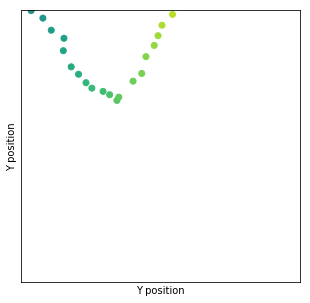

In [67]:
gs = gridspec.GridSpec(2, 2)
fig1 = plt.figure(figsize=(5, 5))
ax1 = fig1.gca()

ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T))
ax1.set_xlim([-Boundary, Boundary])
ax1.set_ylim([-Boundary, Boundary])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylabel('Y position')
ax1.set_xlabel('Y position')

Text(0,0.5,'Δy')

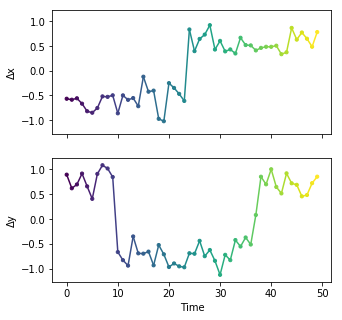

In [68]:
fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
dx_lc.set_array(np.arange(T - 1))
ax2.add_collection(dx_lc)
ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
#ax2.set_xlabel('t')
ax2.set_ylabel('Δx')

dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
dy_lc.set_array(np.arange(T-1))
ax3.add_collection(dy_lc)
ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
ax3.set_xlabel('Time')
ax3.set_ylabel('Δy')

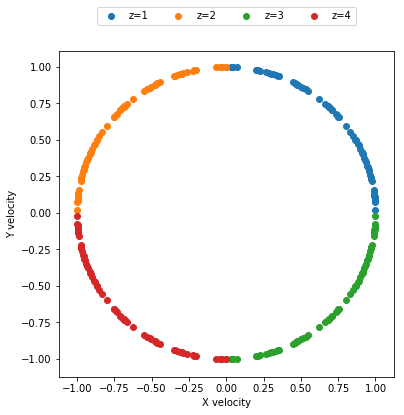

In [69]:
v = np.random.random((100, 2))
v_norm = ((v**2).sum(1))**0.5
v = v / v_norm[:, None]
v = v[v_norm < 1]
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()
ax.scatter(v[:,0], v[:,1], label='z=1')
ax.scatter(-v[:,0], v[:,1], label='z=2')
ax.scatter(v[:,0], -v[:,1], label='z=3')
ax.scatter(-v[:,0], -v[:,1], label='z=4')
ax.set_xlabel('X velocity')
ax.set_ylabel('Y velocity')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)


In [70]:
positions = torch.stack([generative['position_%d' % (t+1)] for t in range(T)], dim=0).cpu().detach()

In [71]:
displacements = torch.stack([generative['displacement_%d' % (t+1)] for t in range(T)], dim=0).cpu().detach()

In [72]:
step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)

In [73]:
velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(-1).to(displacements), displacements[:-1]), dim=-1)

In [74]:
velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(-1).to(displacements) + 1, displacements[1:]), dim=-1)

In [75]:
velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)

In [76]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

Text(0.5,0,'Y position')

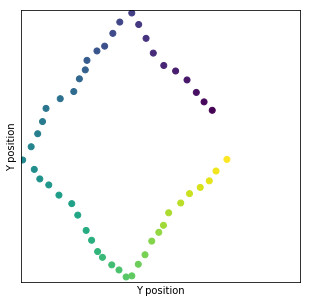

In [77]:
gs = gridspec.GridSpec(2, 2)
fig1 = plt.figure(figsize=(5, 5))
ax1 = fig1.gca()

ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T))
ax1.set_xlim([-Boundary, Boundary])
ax1.set_ylim([-Boundary, Boundary])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylabel('Y position')
ax1.set_xlabel('Y position')

Text(0,0.5,'Δy')

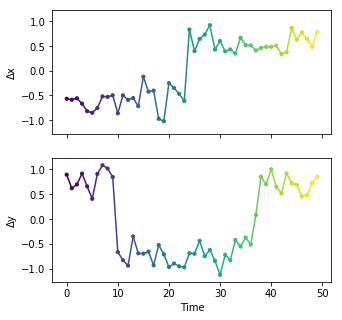

In [78]:
fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
dx_lc.set_array(np.arange(T - 1))
ax2.add_collection(dx_lc)
ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
#ax2.set_xlabel('t')
ax2.set_ylabel('Δx')

dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
dy_lc.set_array(np.arange(T-1))
ax3.add_collection(dy_lc)
ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
ax3.set_xlabel('Time')
ax3.set_ylabel('Δy')